# MATLAB with Amazon SageMaker Processing Job

1. [Getting ECR Images from setup notebook](#1.-Getting-ECR-Image-from-setup-notebook)
   <br> <br>
2. [SageMaker processor](#2.-SageMaker-processor)
   
    1. [Defining network configuration for Processong jobs](#2.1-Defining-network-configuration-for-Processong-jobs)
    2. [Write the MATLAB script `main.m`](#2.2-Write-the-MATLAB-script)
    3. [Running the docker processing container](#2.3-Running-the-docker-processing-container)
    4. [Getting results back and printing accuracy](#2.4-Getting-results-back-from-docker-processing-container-to-SageMaker-instance)

## 1. Getting ECR Image from the `setup.ipynb` notebook

In [ ]:
from sagemaker import get_execution_role
import pandas as pd
import sagemaker
import boto3
import os

role = get_execution_role()
print(role)

You can refer the `setup.ipynb` notebook to create and push your MATLAB docker image to Amazon ECR

In [ ]:
account_id = boto3.client('sts').get_caller_identity().get('Account')
region = boto3.Session().region_name

# Your ECR repo name
ecr_repository = 'sagemaker-demo-ecr'
tag = ':matlab'
processing_repository_uri = '{}.dkr.ecr.{}.amazonaws.com/{}'.format(account_id, region, ecr_repository + tag)

print("ECR Repository Name: ", ecr_repository)
print("ECR Repository URI:", processing_repository_uri)

## 2. SageMaker processor 

### 2.1 Defining network configuration

Follow this documentation from Amazon to give SageMaker Processing Jobs Access to Resources in your Amazon VPC - https://docs.aws.amazon.com/sagemaker/latest/dg/process-vpc.html. 

Make sure that the subnet used below is same subnet that is used to create your Network license manager in section `setup.ipynb` notebook. Create a [NetworkConfig](https://sagemaker.readthedocs.io/en/stable/api/utility/network.html) for processing jobs.



In [ ]:
from sagemaker.network import NetworkConfig
# create processing job for your processor
processing_network_config = NetworkConfig(security_group_ids=["sg-abcdefg123"], 
                                          subnets=["subnet-abcd123"])
print(processing_network_config._to_request_dict())

Intialize the `sagemaker.processing.Processor` using the following arguments -

- `image_uri`:  the processing_repository_uri defined above.
-  `role`: the role defined above.
- `instance_count`: number of instances to spawn in the job.
- `instance_type`: the type of instance to spawn (For more information - https://aws.amazon.com/sagemaker/pricing/).
- `network_config` : Network Configration for processing jobs  
- `env`: environment variable to be passed to the docker instance.
    - added `MLM_LICENSE_FILE` variable generated via the License Manager for MATLAB.
    - added `MATLAB_USERWORKDIR` to specify the start directory for MATLAB.

In [ ]:
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput
#replace with your region & ECR repo name

processor = Processor(
    image_uri=processing_repository_uri,
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge", #replace with required instance
    network_config = processing_network_config,
    env = {"MLM_LICENSE_FILE":"27000@123.12.12.123", 
           "MATLAB_USE_USERWORK":"1", 
           "MATLAB_USERWORKDIR": "/opt/ml/processing/src_files/"} #replace with your network license manager private IP address
)

### 2.2 Write the MATLAB script

The training code is written in the file `main.m`. It is inspired from MathWorks example - [Create Simple Deep Learning Network for Classification](https://www.mathworks.com/help/deeplearning/ug/create-simple-deep-learning-network-for-classification.html). 

Overview of the script - 

- load the digit sample dataset as an [image datastore](https://www.mathworks.com/help/matlab/ref/matlab.io.datastore.imagedatastore.html).
- split the dataset into training & testing set.
- define the convolutional neural network architecture.
- specify training options.
- train the network.
- classify validation images and compute accuracy.


In [ ]:
%%writefile train.m
tic
disp("starting the Deep Learning Example")
disp(pwd)

digitDatasetPath = fullfile(matlabroot,'toolbox','nnet','nndemos', ...
    'nndatasets','DigitDataset');
imds = imageDatastore(digitDatasetPath, ...
    'IncludeSubfolders',true,'LabelSource','foldernames');

disp("dataset loaded in memory")

labelCount = countEachLabel(imds)

numTrainFiles = 750;
[imdsTrain,imdsValidation] = splitEachLabel(imds,numTrainFiles,'randomize');

layers = [
    imageInputLayer([28 28 1])

    convolution2dLayer(3,8,'Padding','same')
    batchNormalizationLayer
    reluLayer

    maxPooling2dLayer(2,'Stride',2)

    convolution2dLayer(3,16,'Padding','same')
    batchNormalizationLayer
    reluLayer

    maxPooling2dLayer(2,'Stride',2)

    convolution2dLayer(3,32,'Padding','same')
    batchNormalizationLayer
    reluLayer

    fullyConnectedLayer(10)
    softmaxLayer
    classificationLayer];

options = trainingOptions('sgdm', ...
    'InitialLearnRate',0.01, ...
    'MaxEpochs',4, ...
    'Shuffle','every-epoch', ...
    'ValidationData',imdsValidation, ...
    'ValidationFrequency',30, ...
    'Verbose',false, ...
    'Plots','training-progress');

disp("Training started")

net = trainNetwork(imdsTrain,layers,options);

disp("Training finsished")

YPred = classify(net,imdsValidation);
YValidation = imdsValidation.Labels;

accuracy = 100*(sum(YPred == YValidation)/numel(YValidation));
toc
disp("Accuracy - " + string(accuracy))

try
    fileID = fopen('/opt/ml/processing/output_data/results.txt','w');
    disp(fileID)
    if fileID==-1
        disp("cannot open file properly")
    else
        fprintf(fileID,'Accuracy - %g\n', accuracy);
        fclose(fileID);
    end
catch
    disp("error saving file to output")
end

### 5.3 Running the docker processing container

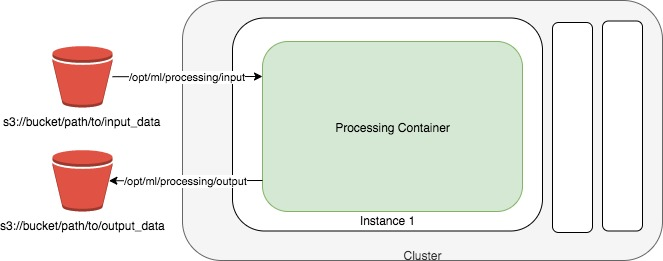

Overview of how SageMaker runs MATLAB via Processing job:

- Uploading `main.m` script file from SageMaker instance to docker processing container.

- In `setup.ipynb` notebook, an ENTRYPOINT was created in the Dockerfile to run the `main.m` script when the docker container runs.

- `main.m` script is uploaded to the `/opt/ml/processing/src_files/` directory of the docker processing container, which is specified as `MATLAB_USERWORKDIR` in the Processor configuration above.

- Processor gets the `/opt/ml/processing/output_data` directory back from the docker processing container as a ProcessingOutput object.


In [ ]:
%%time
processor.run(
    inputs=
    [ProcessingInput(
        source='/home/ec2-user/SageMaker/train.m', #location to your main.m script
        destination='/opt/ml/processing/src_files/'),
    ],
    outputs = [
        ProcessingOutput(
            output_name="results",
            source="/opt/ml/processing/output_data",
        ),
    ]
)

### 5.4 Getting results back from processing container to SageMaker instance

We get the `ProcessingOutputConfig` field from latest processing job. 

In our `main.m` script, we stored the accuracy in a `results.txt` file, which is stored in an S3 location. We extract the S3 path of the `results.txt` from the latest processing job, read the contents of the file via [`pd.read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function and print the accuracy. 

In [ ]:
# get the output of the latest processing job
preprocessing_job_description = processor.jobs[-1].describe()
output_config = preprocessing_job_description["ProcessingOutputConfig"]
print(output_config)

In [ ]:
# get results.txt file from output
s3_output_dir = output_config['Outputs'][0]['S3Output']['S3Uri']
s3_result = os.path.join(s3_output_dir, "results.txt")

In [ ]:
# read s3 csv file using pandas library
df = pd.read_csv('results.txt', header=None)

In [ ]:
# print the accuracy
print(df[0][0])